## PLINK GWAS Population Stratification Tutorial

These commands walk through downloading 1000 Genomes (1KG) data, merging it with HapMap data, and then running an MDS projection into 2 dimensions to visualize how well the HapMap population aligns with the different populations in the 1KG data.

As in all PLINK tutorials, the comments and code from the original tutorial are included with R steps commented out (and replaced by python where necessary) and to disambiguate between comments from the original authors and me, the ```#*#``` character is used.

In [1]:
import os.path as osp
import pandas as pd
import plotnine as pn
%run ../init/benchmark.py
register_timeop_magic(get_ipython(), 'plink')
prev_dir = osp.expanduser('~/data/gwas/tutorial/1_QC_GWAS')
data_dir = osp.expanduser('~/data/gwas/tutorial/2_PS_GWAS')
data_dir

'/home/eczech/data/gwas/tutorial/2_PS_GWAS'

Copy necessary data from directory for first step in tutorial to directory for next step:

In [6]:
%%timeop -o ps0
%%bash -s "$prev_dir" "$data_dir"
set -e
echo "$1 $2"
cp $1/HapMap_3_r3_12.* $2/
cp $1/indepSNP.prune.in $2/

/home/eczech/data/gwas/tutorial/1_QC_GWAS /home/eczech/data/gwas/tutorial/2_PS_GWAS
Elapsed time: 0.1 seconds


### Step 1: Convert VCF to PLINK

**NOTE**: If you are running this yourself, run the ```wget``` command below with your preferred method for long running background processes as it may take a while (~4 hours in my case)

In [2]:
%%timeop -o ps1-convert
%%bash -s "$data_dir"
set -e; cd $1

## Download 1000 Genomes data ##
# This file from the 1000 Genomes contains genetic data of 629 individuals from different ethnic backgrounds.
# Note, this file is quite large (>60 gigabyte).  
#*# Do this externally in background process:
# wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz

# Convert vcf to Plink format.
plink --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz --make-bed --out ALL.2of4intersection.20100804.genotypes

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ALL.2of4intersection.20100804.genotypes.log.
Options in effect:
  --make-bed
  --out ALL.2of4intersection.20100804.genotypes
  --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz

128535 MB RAM detected; reserving 64267 MB for main workspace.
--vcf: ALL.2of4intersection.20100804.genotypes-temporary.bed +
ALL.2of4intersection.20100804.genotypes-temporary.bim +
ALL.2of4intersection.20100804.genotypes-temporary.fam written.
25488488 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ALL.2of4intersection.20100804.genotypes.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

Note that the original 62G gzipped vcf converts to a ~4.5G PLINK dataset:

In [5]:
%%bash -s "$data_dir"
set -e
cd $1
du -ch ALL.2of4intersection.20100804.genotypes*

3.8G	ALL.2of4intersection.20100804.genotypes.bed
607M	ALL.2of4intersection.20100804.genotypes.bim
16K	ALL.2of4intersection.20100804.genotypes.fam
4.0K	ALL.2of4intersection.20100804.genotypes.log
12K	ALL.2of4intersection.20100804.genotypes.nosex
62G	ALL.2of4intersection.20100804.genotypes.vcf.gz
66G	total


In [2]:
%%timeop -o ps1-assignrsid
%%bash -s "$data_dir"
set -e
cd $1

# Noteworthy, the file 'ALL.2of4intersection.20100804.genotypes.bim' contains SNPs without an rs-identifier, these SNPs are indicated with ".". This can also be observed in the file 'ALL.2of4intersection.20100804.genotypes.vcf.gz'. To check this file use this command: zmore ALL.2of4intersection.20100804.genotypes.vcf.gz .
# The missing rs-identifiers in the 1000 Genomes data are not a problem for this tutorial.
# However, for good practice, we will assign unique indentifiers to the SNPs with a missing rs-identifier (i.e., the SNPs with ".").
plink --bfile ALL.2of4intersection.20100804.genotypes --set-missing-var-ids @:#[b37]\$1,\$2 --make-bed --out ALL.2of4intersection.20100804.genotypes_no_missing_IDs

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ALL.2of4intersection.20100804.genotypes_no_missing_IDs.log.
Options in effect:
  --bfile ALL.2of4intersection.20100804.genotypes
  --make-bed
  --out ALL.2of4intersection.20100804.genotypes_no_missing_IDs
  --set-missing-var-ids @:#[b37]$1,$2

128535 MB RAM detected; reserving 64267 MB for main workspace.
25488488 variants loaded from .bim file.
10375501 missing IDs set.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
ALL.2of4intersection.20100804.genotypes_no_missing_IDs.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798

### Step 2: QC for Missingness and MAF

Much like as was done with the HapMap data in QC steps, remove samples and variants with low call rates:

In [37]:
%%timeop -o ps2
%%bash -s "$data_dir"
set -e; cd $1

## QC on 1000 Genomes data.
# Remove variants based on missing genotype data.

#*# The "--allow-no-sex" flag has no effect here in PLINK 1.9 but in 1.07 (what the tutorial publication was run with),
#*# it appears that many operations are limited to founders with sex codes and this flag omits the latter filter;
#*# here though, the files produced {.bed,.bim,.fam} are all 100% identical with or without it
plink --bfile ALL.2of4intersection.20100804.genotypes_no_missing_IDs --geno 0.2 --allow-no-sex --make-bed --out 1kG_MDS
printf '=%.0s' {1..80}; echo # HR

# Remove individuals based on missing genotype data.
plink --bfile 1kG_MDS --mind 0.2 --allow-no-sex --make-bed --out 1kG_MDS2
printf '=%.0s' {1..80}; echo # HR

# Remove variants based on missing genotype data.
plink --bfile 1kG_MDS2 --geno 0.02 --allow-no-sex --make-bed --out 1kG_MDS3
printf '=%.0s' {1..80}; echo # HR

# Remove individuals based on missing genotype data.
plink --bfile 1kG_MDS3 --mind 0.02 --allow-no-sex --make-bed --out 1kG_MDS4
printf '=%.0s' {1..80}; echo # HR

# Remove variants based on MAF.
plink --bfile 1kG_MDS4 --maf 0.05 --allow-no-sex --make-bed --out 1kG_MDS5

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1kG_MDS.log.
Options in effect:
  --allow-no-sex
  --bfile ALL.2of4intersection.20100804.genotypes_no_missing_IDs
  --geno 0.2
  --make-bed
  --out 1kG_MDS

128535 MB RAM detected; reserving 64267 MB for main workspace.
25488488 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to 1kG_MDS.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.615305.
16481066 variants removed due to missing genotype data (--geno).
9007422 variant

### Step 3: Alignment

Overview of operations:
1. Determine which variants are in both HapMap and 1KG
2. Create filtered HapMap and 1KG datasets that contain ONLY shared variants
3. Update the 1KG data to have the same genomic positions and alleles for the shared variants as in HapMap
  - This variant liftover step is done in an ad-hoc fashion here by using direct rsid -> loci assignments and inferring strand conflicts
  between the two builds based on alleles (e.g. "minor = A, major = C" in one build and "minor = T, major = G" in another indicates opposite strand)
  - A more general approach to this like that taken in Hail (see [variant liftover](https://hail.is/docs/0.2/guides/genetics.html#liftover-howto)) is better because it operates based on loci mappings alone (using a [chain](https://genome.ucsc.edu/goldenPath/help/chain.html) file) rather than requiring that the variant names in the two datasets be compatible.

PLINK notes for this step:

- The [--extract](https://www.cog-genomics.org/plink/1.9/filter#snp) flag tells PLINK to read all rsids from a file and remove any variants not present in that file
- The [--recode](https://www.cog-genomics.org/plink/1.9/data#recode) option tells PLINK to produce [.map](https://www.cog-genomics.org/plink/1.9/formats#map) and [.ped](https://www.cog-genomics.org/plink/1.9/formats#ped) files, which contain the same information as the combination of .bed, .bim, and .fam files but are an older, less efficient (but non-binary) format
- The [--made-bed](https://www.cog-genomics.org/plink/1.9/data#make_bed) option functions similarly to ```--recode``` except that it forces the production of .bed, .bim, and .fam file instead
- The command below ending with ```--recode --make-bed --out HapMap_MDS``` produces both types of PLINK datasets
    - The .ped/.map format is WAY larger:
    
```
    > du -ch HapMap_MDS.*
    27M  HapMap_MDS.bed
    27M  HapMap_MDS.bim
    4.0K HapMap_MDS.fam
    4.0K HapMap_MDS.log
    23M  HapMap_MDS.map
    417M HapMap_MDS.ped
```
- The [--update-map](https://www.cog-genomics.org/plink/1.9/data#update_map) command will use a file containing an rsid and new base-pair coordinate to map all rsids in the input dataset to the same coordinate.  If the rsid is not in the mapping file, its coordinate is not updated
  - The PLINK docs don't mention that unmapped rsids are ignored
  - In the last command below like ```--bfile 1kG_MDS6 --update-map buildhapmap.txt```, this is not a concern though since ```1kG_MDS6``` was built in a way to  guarantee that these unmapped rsids aren't possible

In [36]:
%%timeop -o ps3
%%bash -s "$data_dir"
set -e; cd $1

# Extract the variants present in HapMap dataset from the 1000 genomes dataset.
#*# Note: field 2 is the rsid in the bim file
awk '{print$2}' HapMap_3_r3_12.bim > HapMap_SNPs.txt
plink --bfile 1kG_MDS5 --extract HapMap_SNPs.txt --make-bed --out 1kG_MDS6
printf '=%.0s' {1..80}; echo # HR

# Extract the variants present in 1000 Genomes dataset from the HapMap dataset.
#*# Again, field 2 is the rsid in the bim file
awk '{print$2}' 1kG_MDS6.bim > 1kG_MDS6_SNPs.txt
plink --bfile HapMap_3_r3_12 --extract 1kG_MDS6_SNPs.txt --recode --make-bed --out HapMap_MDS
printf '=%.0s' {1..80}; echo # HR
# The datasets now contain the exact same variants.

## The datasets must have the same build. Change the build 1000 Genomes data build.
echo "> head -n 3 HapMap_MDS.map ------------------------"
head -n 3 HapMap_MDS.map
echo "---------------------------------------------------"

#*# Field 2 is the rsid, field 4 is the base-pair coordinate
awk '{print$2,$4}' HapMap_MDS.map > buildhapmap.txt
# buildhapmap.txt contains one SNP-id and physical position per line.

plink --bfile 1kG_MDS6 --update-map buildhapmap.txt --make-bed --out 1kG_MDS7
# 1kG_MDS7 and HapMap_MDS now have the same build.

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1kG_MDS6.log.
Options in effect:
  --bfile 1kG_MDS5
  --extract HapMap_SNPs.txt
  --make-bed
  --out 1kG_MDS6

128535 MB RAM detected; reserving 64267 MB for main workspace.
5808310 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to 1kG_MDS6.nosex .
--extract: 1000993 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999411.
1000993 variants and 629 people pass filters and QC.
Note: No phenotypes present.
--mak

Elapsed time: 7.0 seconds


### Step 4: Merge 1KG with HapMap Data

Overview of operations:
1. Given 1KG and HapMap datasets have the same variants, allele order will be harmonized
  - In other words, if the strand changed between genome builds then a major allele that was originally ```A``` will become ```T``` (same for ```C``` and ```G```).  Since these 1KG and HapMap datasets are from different builds, this situation is likely and will be dealt with by conforming the HapMap strand order to the 1KG order.
2. Merge the HapMap and 1KG datasets into a single dataset
  - If you think of the datasets as having variants in the rows and samples into the columns, this equates to concatenating them horizontally (i.e. the variants are already the same but the calls for the samples need to be merged)
  
PLINK notes for this step:

In the PLINK docs, the two alleles in a .bim file are often referred to as ```A1``` and ```A2```.  This vague definition is used to make it possible for commands to operate on either ordering of alleles, i.e. minor then major or major then minor (but the convention is that **A1 = the minor allele**).  This is important to keep in mind because the the ```--reference-allele``` command below takes a mapping from rsids to **minor** alleles and then reorders each allele pair in the input file to match that mapping.

In [12]:
## Merge the HapMap and 1000 Genomes data sets

# Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable, for this we conduct 3 steps:
# 1) Make sure the reference genome is similar in the HapMap and the 1000 Genomes Project datasets.
# 2) Resolve strand issues.
# 3) Remove the SNPs which after the previous two steps still differ between datasets.

# The following steps are maybe quite technical in terms of commands, but we just compare the two data sets and make sure they correspond.

In [29]:
%%timeop -o ps4-set-ref-genome
%%bash -s "$data_dir"
set -e; cd $1

# 1) set reference genome 
#*# Show a few rows from 1kG_MDS7.bim first so we can see what's going on in the creation of 1kg_ref-list.txt
echo "> head -n 3 1kG_MDS7.bim ------------------------"
head -n 3 1kG_MDS7.bim
echo "-------------------------------------------------"
#*# Field 2 is the rsid, field 5 is the *minor* allele according to https://www.cog-genomics.org/plink/1.9/formats#bim
awk '{print$2,$5}' 1kG_MDS7.bim > 1kg_ref-list.txt


#*# WARNING: that the stderr for this command is redirected.  This has been done because the original authors
#*# only mention this as "This command will generate some warnings" but there are hundreds of them.  The nature
#*# of these warnings is detailed in the following cells
plink --bfile HapMap_MDS --reference-allele 1kg_ref-list.txt --make-bed --out HapMap-adj 2> HapMap-adj.err
# The 1kG_MDS7 and the HapMap-adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.

> head -n 3 1kG_MDS7.bim ------------------------
1	rs3131969	0	744045	A	G
1	rs1048488	0	750775	C	T
1	rs12562034	0	758311	A	G
-------------------------------------------------
PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap-adj.log.
Options in effect:
  --a1-allele 1kg_ref-list.txt
  --bfile HapMap_MDS
  --make-bed
  --out HapMap-adj

128535 MB RAM detected; reserving 64267 MB for main workspace.
1000993 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 do

<hr>

Note that the last command above actually generated 809 redirected warnings (to ```HapMap-adj.err```).  These warnings look like:

```
Warning: Impossible A1 allele assignment for variant rs11488462.
Warning: Impossible A1 allele assignment for variant rs4648786.
Warning: Impossible A1 allele assignment for variant rs28635343.
Warning: Impossible A1 allele assignment for variant rs28456011.
```

What this means is that the ```1kg_ref-list.txt``` specified an rsid as having a minor allele that doesn't match either of the alleles encountered in the HapMap data.  See an example of this here where the first variant in the warnings (**rs11488462**) has ```C``` (minor) and ```T``` (major) alleles in the 1KG data but ```G``` and ```A``` alleles in the HapMap data:

```
# Variant data in HapMap
> cat HapMap-adj.bim | grep rs11488462
1	rs11488462	0	1343243	G	A

# Variant data in 1KG
> cat 1kG_MDS7.bim | grep rs11488462
1	rs11488462	0	1343243	C	T

# Expected variant minor allele
> cat 1kg_ref-list.txt | grep rs11488462
rs11488462 C
```

This results from the variant being on different strands in different genome builds.  The steps below try to reconcile this, and this is what the tutorial authors mean by "Resolve strand issues" in their comments.

In [39]:
%%timeop -o ps4-strand-issues
%%bash -s "$data_dir"
set -e; cd $1

# 2) Resolve strand issues.
# Check for potential strand issues.
#*# This will write all rsid, minor allele, major allele combinations for 1KG and HapMap to a file
awk '{print$2,$5,$6}' 1kG_MDS7.bim > 1kGMDS7_tmp
awk '{print$2,$5,$6}' HapMap-adj.bim > HapMap-adj_tmp
#*# This command will determine which rsid, minor allele, major allele combinations DO NOT exist in both datasets
sort 1kGMDS7_tmp HapMap-adj_tmp |uniq -u > all_differences.txt
# 1624 differences between the files, some of these might be due to strand issues.

## Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' all_differences.txt | sort -u > flip_list.txt
# Generates a file of 812 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 812 non-corresponding SNPs. 
#*# This PLINK command flips the strand associated with allele encodings (i.e. A/T becomes C/G)
plink --bfile HapMap-adj --flip flip_list.txt --reference-allele 1kg_ref-list.txt --make-bed --out corrected_hapmap
printf '=%.0s' {1..80}; echo # HR

# Check for SNPs which are still problematic after they have been flipped.
#*# The tutorial authors appear to throw up their hands here but an explanation for why this catch-all statment 
#*# is needed is in the cells below (these remaining issues are due to allele conflicts)
awk '{print$2,$5,$6}' corrected_hapmap.bim > corrected_hapmap_tmp
sort 1kGMDS7_tmp corrected_hapmap_tmp |uniq -u  > uncorresponding_SNPs.txt
# This file demonstrates that there are 84 differences between the files.

# 3) Remove problematic SNPs from HapMap and 1000 Genomes.
awk '{print$1}' uncorresponding_SNPs.txt | sort -u > SNPs_for_exlusion.txt
# The command above generates a list of the 42 SNPs which caused the 84 differences between the HapMap and the 1000 Genomes data sets after flipping and setting of the reference genome.

# Remove the 42 problematic SNPs from both datasets.
plink --bfile corrected_hapmap --exclude SNPs_for_exlusion.txt --make-bed --out HapMap_MDS2
printf '=%.0s' {1..80}; echo # HR
plink --bfile 1kG_MDS7 --exclude SNPs_for_exlusion.txt --make-bed --out 1kG_MDS8

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to corrected_hapmap.log.
Options in effect:
  --a1-allele 1kg_ref-list.txt
  --bfile HapMap-adj
  --flip flip_list.txt
  --make-bed
  --out corrected_hapmap

128535 MB RAM detected; reserving 64267 MB for main workspace.
1000993 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
--flip: 812 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998031.
--a1-allele: 1000993 assignments made.
1000993 variants and 109 people pass 

Elapsed time: 6.3 seconds


<hr>

Before moving on, pause for a second and take a look closer at the step originally defined as:
    
```
# Check for SNPs which are still problematic after they have been flipped.
awk '{print$2,$5,$6}' corrected_hapmap.bim > corrected_hapmap_tmp
sort 1kGMDS7_tmp corrected_hapmap_tmp |uniq -u  > uncorresponding_SNPs.txt
```

The SNPs in question here appear to all have the common property that they are simply incompatible in the 1KG and HapMap datasets.  For example, the commands below show that one variant has A/C alleles in HapMap but C/T in 1KG (both are transversions):
    
```
> cat corrected_hapmap.bim | grep rs10116901
9	rs10116901	0	3816440	C	A

> cat 1kG_MDS7.bim | grep rs10116901
9	rs10116901	0	3816440	C	T
```

There are only 84 of them though:

```
> cat uncorresponding_SNPs.txt | wc -l
84
```

It likely makes sense to ignore these before moving on to merging the datasets, but their origin is still suspicious.

In [40]:
%%timeop -o ps4-merge
%%bash -s "$data_dir"
set -e; cd $1

# Note, we are fully aware of the sample overlap between the HapMap and 1000 Genomes datasets. However, for the purpose of this tutorial this is not important.
#*# This is a pretty important caveat from the authors, that some of the individuals have the same ids in both datasets.  
#*# In this tutorial, they will be assigned a different family id since HapMap has family ids and 1KG does not so for all 
#*# PLINK downstream steps they will be treated as separate individuals.

# Merge HapMap with 1000 Genomes Data.
plink --bfile HapMap_MDS2 --bmerge 1kG_MDS8.bed 1kG_MDS8.bim 1kG_MDS8.fam --allow-no-sex --make-bed --out MDS_merge2

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDS_merge2.log.
Options in effect:
  --allow-no-sex
  --bfile HapMap_MDS2
  --bmerge 1kG_MDS8.bed 1kG_MDS8.bim 1kG_MDS8.fam
  --make-bed
  --out MDS_merge2

128535 MB RAM detected; reserving 64267 MB for main workspace.
109 people loaded from HapMap_MDS2.fam.
629 people to be merged from 1kG_MDS8.fam.
Of these, 629 are new, while 0 are present in the base dataset.
1000951 markers loaded from HapMap_MDS2.bim.
1000951 markers to be merged from 1kG_MDS8.bim.
Of these, 0 are new, while 1000951 are present in the base dataset.
Performing single-pass merge (738 people, 1000951 variants).
Merged fileset written to MDS_merge2-merge.bed + MDS_merge2-merge.bim +
MDS_merge2-merge.fam .
1000951 variants loaded from .bim file.
738 people (55 males, 54 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to MDS_merge2.

Elapsed time: 5.2 seconds


The ```Multiple chromosomes seen for variant 'rs1640558'``` occurs because the chromosomes associated with this variant differ in the 1KG and HapMap datsets:

In [53]:
%%timeop -o ps4-strand-issues
%%bash -s "$data_dir"
set -e; cd $1
cat 1kG_MDS8.bim | grep rs1640558
cat MDS_merge2.bim | grep rs1640558

7	rs1640558	0	97808907	G	A
10	rs1640558	0	97808907	G	A
Elapsed time: 0.1 seconds


### Step 5: MDS

The [--genome](https://www.cog-genomics.org/plink/1.9/ibd) PLINK flag will result in creation of a file containing a row for each pair of samples in the dataset with columns corresponding to useful statistics from an identity by descent calculation.  The "DST" field in this file ("IBS distance") is the distance measure used in MDS.

In [51]:
%%timeop -o ps5
%%bash -s "$data_dir"
set -e; cd $1

## Perform MDS on HapMap-CEU data anchored by 1000 Genomes data.
# Using a set of pruned SNPs

#*# Variants are filtered to independent variants resulting from variant pruning in the QC step
plink --bfile MDS_merge2 --extract indepSNP.prune.in --genome --out MDS_merge2
printf '=%.0s' {1..80}; echo # HR
head MDS_merge2.genome #*# IBS data rows
printf '=%.0s' {1..80}; echo # HR
plink --bfile MDS_merge2 --read-genome MDS_merge2.genome --cluster --mds-plot 10 --out MDS_merge2
printf '=%.0s' {1..80}; echo # HR
head MDS_merge2.mds #*# MDS data rows

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDS_merge2.log.
Options in effect:
  --bfile MDS_merge2
  --extract indepSNP.prune.in
  --genome
  --out MDS_merge2

128535 MB RAM detected; reserving 64267 MB for main workspace.
1000951 variants loaded from .bim file.
738 people (55 males, 54 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to MDS_merge2.nosex .
109 phenotype values loaded from .fam.
--extract: 93331 variants remaining.
Using up to 15 threads (change this with --threads).
Before main variant filters, 738 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99925.
93331 variants and 738 people pass filters a

### Step 6: Visualize and Filter Outliers

In [44]:
%%bash -s "$data_dir"
set -e; cd $1

# Download the file with population information of the 1000 genomes dataset.
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel
# The file 20100804.ALL.panel contains population codes of the individuals of 1000 genomes.

head 20100804.ALL.panel
printf '=%.0s' {1..80}; echo # HR

# Convert population codes into superpopulation codes (i.e., AFR,AMR,ASN, and EUR).
awk '{print$1,$1,$2}' 20100804.ALL.panel > race_1kG.txt
sed 's/JPT/ASN/g' race_1kG.txt>race_1kG2.txt
sed 's/ASW/AFR/g' race_1kG2.txt>race_1kG3.txt
sed 's/CEU/EUR/g' race_1kG3.txt>race_1kG4.txt
sed 's/CHB/ASN/g' race_1kG4.txt>race_1kG5.txt
sed 's/CHD/ASN/g' race_1kG5.txt>race_1kG6.txt
sed 's/YRI/AFR/g' race_1kG6.txt>race_1kG7.txt
sed 's/LWK/AFR/g' race_1kG7.txt>race_1kG8.txt
sed 's/TSI/EUR/g' race_1kG8.txt>race_1kG9.txt
sed 's/MXL/AMR/g' race_1kG9.txt>race_1kG10.txt
sed 's/GBR/EUR/g' race_1kG10.txt>race_1kG11.txt
sed 's/FIN/EUR/g' race_1kG11.txt>race_1kG12.txt
sed 's/CHS/ASN/g' race_1kG12.txt>race_1kG13.txt
sed 's/PUR/AMR/g' race_1kG13.txt>race_1kG14.txt

# Create a racefile of your own data.
awk '{print$1,$2,"OWN"}' HapMap_MDS.fam>racefile_own.txt

# Concatenate racefiles.
cat race_1kG14.txt racefile_own.txt | sed -e '1i\FID IID race' > racefile.txt
head racefile.txt

HG00098	GBR	ILLUMINA
HG00100	GBR	ILLUMINA
HG00106	GBR	ILLUMINA
HG00112	GBR	ILLUMINA
HG00114	GBR	ILLUMINA
HG00116	GBR	ILLUMINA
HG00117	GBR	ILLUMINA
HG00118	GBR	ILLUMINA
HG00119	GBR	ILLUMINA
HG00120	GBR	ILLUMINA
FID IID race
HG00098 HG00098 EUR
HG00100 HG00100 EUR
HG00106 HG00106 EUR
HG00112 HG00112 EUR
HG00114 HG00114 EUR
HG00116 HG00116 EUR
HG00117 HG00117 EUR
HG00118 HG00118 EUR
HG00119 HG00119 EUR


Load the datasets generated above, merge them, and then visualize the results.  This is a port of the R code in MDS_merged.R:

In [62]:
df_mds = pd.read_csv(osp.join(data_dir, "MDS_merge2.mds"), sep="\s+")
# Join to racefile (FID, IID, race) and ensure all rows match
df_mds = pd.merge(df_mds, pd.read_csv(osp.join(data_dir, "racefile.txt"), sep="\s+"), on=['FID', 'IID'], how='left')
assert df_mds['race'].notnull().all()
df_mds.head()

,FID,IID,SOL,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,race
0,1328,NA06984,0,-0.056675,0.048428,-0.004488,0.004657,-0.021231,0.023367,-0.000379,0.000164,-0.036388,0.030325,OWN
1,1328,NA06989,0,-0.056987,0.047895,-0.009145,0.010935,-0.007569,0.036984,0.021047,-0.092013,-0.012652,0.014856,OWN
2,1330,NA12340,0,-0.057024,0.048794,-0.005250,0.009152,0.005329,0.008672,-0.017675,0.013394,-0.036391,-0.000422,OWN
3,1330,NA12341,0,-0.054879,0.048044,-0.009447,0.008095,-0.009400,0.002265,-0.007347,-0.015724,0.010848,0.010350,OWN
4,1330,NA12343,0,-0.056785,0.044751,-0.001812,0.000999,-0.004471,0.003395,0.000353,-0.001717,-0.000712,0.000386,OWN


In [144]:
df_mds['race'].value_counts()

EUR    261
ASN    177
AFR    169
OWN    109
AMR     22
Name: race, dtype: int64

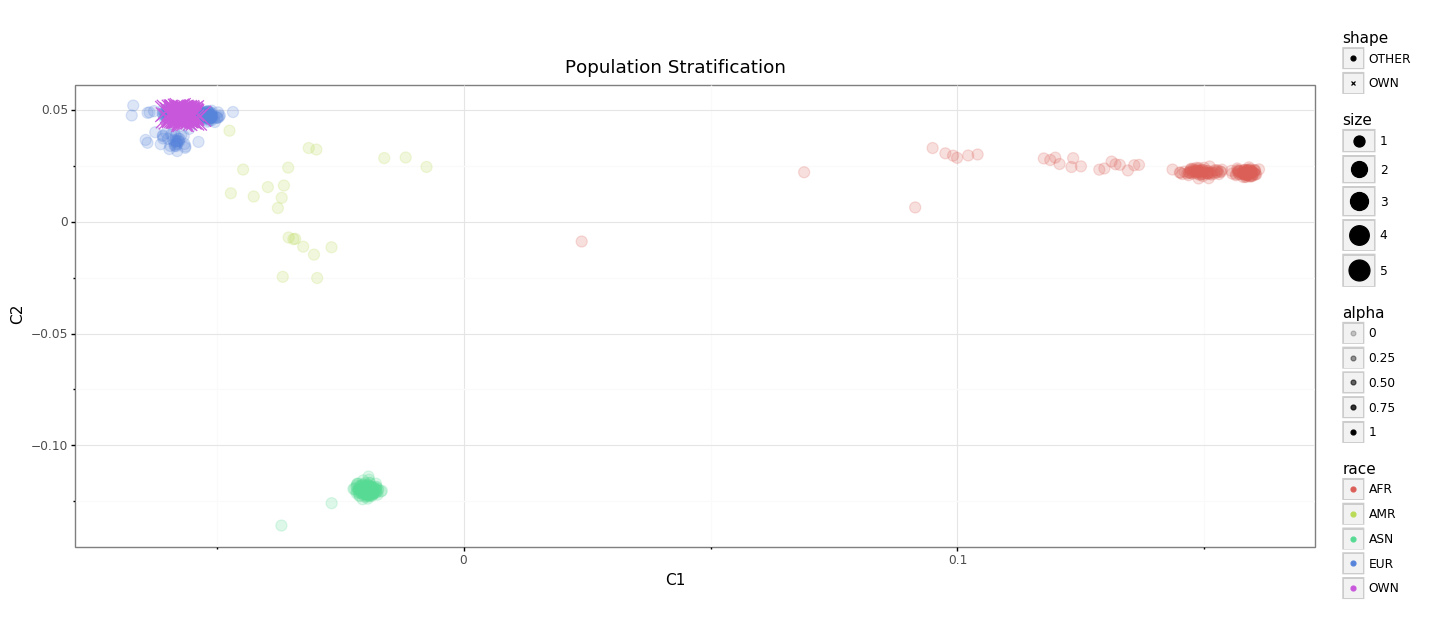

<ggplot: (8769804475633)>

In [133]:
def mds_plot(df):
    return (
        pn.ggplot(
            df
                .assign(alpha=lambda df: df['race'].apply(lambda v: 1 if v == 'OWN' else 0))
                .assign(size=lambda df: df['race'].apply(lambda v: 5 if v == 'OWN' else 1))
                .assign(shape=lambda df: df['race'].apply(lambda v: 'OWN' if v == 'OWN' else 'OTHER'))
            , 
            pn.aes(x='C1', y='C2', fill='race', color='race', shape='shape', alpha='alpha', size='size')
        ) +
        pn.geom_point() + 
        pn.scale_shape_manual(values=['o', 'x']) +
        pn.scale_size_continuous(range=(4, 8)) + 
        pn.scale_alpha_continuous(range=(.2, 1)) +
        pn.theme_bw() +
        pn.labs(title='Population Stratification') + 
        pn.theme(figure_size=(16, 6)) 
    )
mds_plot(df_mds)

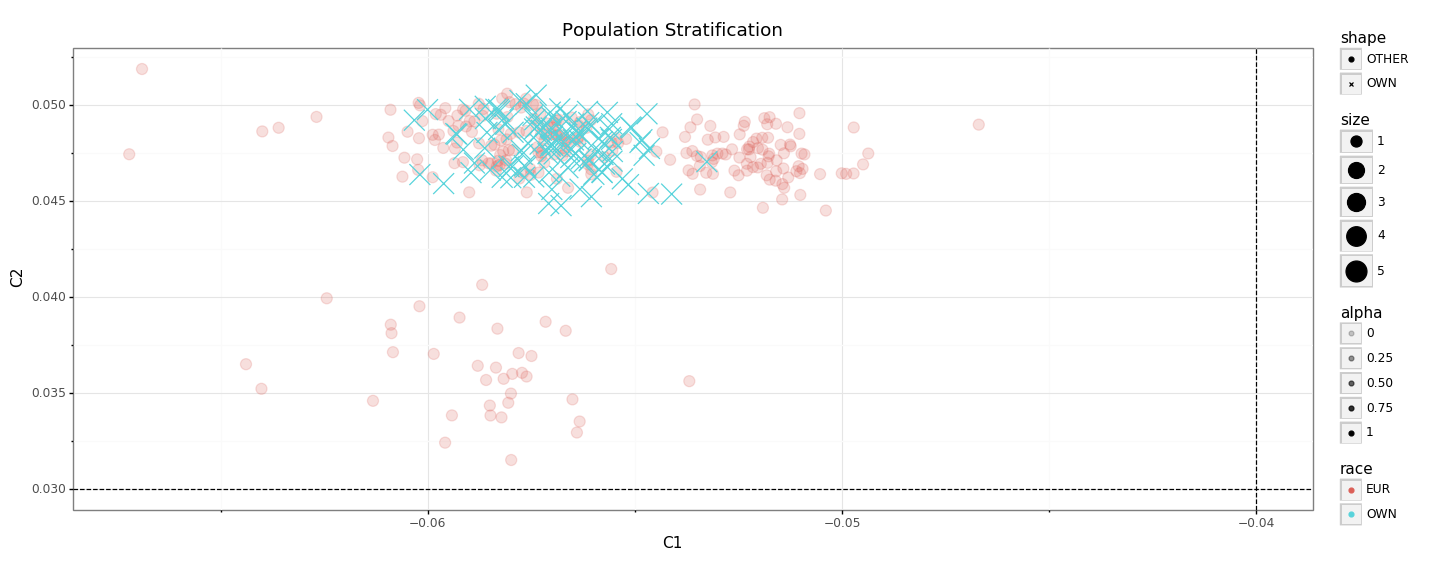

<ggplot: (8769677095433)>

In [134]:
# Zoom in on OWN + EUR populations and show proposed tutorial filter thresholds
mds_plot(df_mds.pipe(lambda df: df[df['race'].isin(['OWN', 'EUR'])])) + \
    pn.geom_hline(yintercept=.03, linetype='--') +  \
    pn.geom_vline(xintercept=-.04, linetype='--')

Lastly, filter any samples that aren't genetically similar to the 1KG European population.  The above plot shows that there are no outliers but the code to do the filtering is run below anyhow:

In [135]:
%%bash -s "$data_dir"
set -e; cd $1

## Exclude ethnic outliers.
# Select individuals in HapMap data below cut-off thresholds. The cut-off levels are not fixed thresholds but have to be determined based on the visualization of the first two dimensions. To exclude ethnic outliers, the thresholds need to be set around the cluster of population of interest.
#*# This file will include every sample in HapMap and all EUR samples in 1KG
awk '{ if ($4 <-0.04 && $5 >0.03) print $1,$2 }' MDS_merge2.mds > EUR_MDS_merge2

# Extract these individuals in HapMap data.
#*# The 1KG sample ids will be ignored when given as a filter here
plink --bfile HapMap_3_r3_12 --keep EUR_MDS_merge2 --make-bed --out HapMap_3_r3_13
printf '=%.0s' {1..80}; echo # HR
# Note, since our HapMap data did include any ethnic outliers, no individuls were removed at this step. However, if our data would have included individuals outside of the thresholds we set, then these individuals would have been removed.

## Create covariates based on MDS.
# Perform an MDS ONLY on HapMap data without ethnic outliers. The values of the 10 MDS dimensions are subsequently used as covariates in the association analysis in the third tutorial.
plink --bfile HapMap_3_r3_13 --extract indepSNP.prune.in --genome --out HapMap_3_r3_13
printf '=%.0s' {1..80}; echo # HR
plink --bfile HapMap_3_r3_13 --read-genome HapMap_3_r3_13.genome --cluster --mds-plot 10 --out HapMap_3_r3_13_mds

# Change the format of the .mds file into a plink covariate file.
awk '{print$1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' HapMap_3_r3_13_mds.mds > covar_mds.txt

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_13.log.
Options in effect:
  --bfile HapMap_3_r3_12
  --keep EUR_MDS_merge2
  --make-bed
  --out HapMap_3_r3_13

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
--keep: 109 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998023.
1073226 variants and 109 people pass filters and QC.
Among remaining phenotypes, 55 are cases and 54 a

In [145]:
%%bash -s "$data_dir"
set -e; cd $1
cat covar_mds.txt | head

FID IID C1 C2 C3 C4 C5 C6 C7 C8 C9 C10
1328 NA06989 0.012049 -0.0519013 0.0535676 0.00343547 -0.00932171 0.00695469 -0.0179691 0.0300903 -0.0178852 0.00534993
1377 NA11891 0.00688179 -0.031908 -0.00498184 -0.0294468 0.0144568 0.019479 -0.000116662 0.00746505 -0.00374285 -0.0325711
1349 NA11843 0.000885261 0.011968 -0.00410012 0.0110895 0.0144349 -0.0175293 0.00745591 -0.0145733 0.0105628 -0.00128705
1330 NA12341 -0.0139131 -0.0103009 0.0031959 -0.0061788 -0.0268079 -0.0105812 0.0316143 0.00174773 0.0227386 -0.0184979
1328 NA06984 0.00894536 0.0114052 0.0196157 0.020365 0.00872312 -0.0101587 0.0146974 0.0209611 -0.0040181 0.0189313
1418 NA12275 -0.012316 -0.00492699 -0.00948485 -0.0162676 -0.0204782 0.0104956 -0.0309242 -0.00501868 -0.00350087 0.000168308
13291 NA06986 0.000758713 0.00995573 0.00496042 0.0210376 0.0226693 0.00514946 0.00553343 -0.00362475 0.0239537 -0.0178775
1418 NA12272 -0.0108685 -0.00740207 -0.0107244 0.0188304 -0.00755315 -0.0112149 0.0158753 -0.0131965 0.0103859 -

**Conclusion**

And that's it.  The ```HapMap_3_r3_13``` file now contains pruned variants and no samples outside of the expected population (though in this case none were actually removed) and the ```covar_mds.txt``` file contains MDS coordinates for all HapMap samples to be used in the next GWAS regression step.